In [1]:
##Packages for segmentation. Pretty positive we do not need anything else but feel free
##To import packages 

import os
from PIL import Image
import numpy as np
import pims
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io, feature, filters
from skimage.segmentation import watershed, active_contour
from skimage.feature import peak_local_max
import skimage.morphology as morphology
from scipy import ndimage as ndi
import skimage
import random
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import KendallShapeMetric, PreShapeSpace
from geomstats.visualization import KendallDisk, KendallSphere

import pylab

INFO: Using numpy backend


In [2]:
##Functions for tracker go here
##Add document strings to any function you write please

def get_frames(movie_location):
    vidcap = cv2.VideoCapture(movie_location)
    success,image = vidcap.read()
    count = 0

    ##Storage for movie frames
    movie = []
    while success:
        cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
        success,image = vidcap.read()
        #print('Read a new frame: ', success)
        if success==False:
            break
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        movie.append(image)
        count += 1

    ##Change to numpy array
    np.asarray(movie)
    
    return movie


def segmentation(predict_array):
    '''Makes segmentation mask from NIBI-predicted nuclei.
    
    INPUT: [N,W,H] matrix where N is number of images and W,H are width and height of image respectivly. 
    Images should be in Numpy UInt16 format for processing.
    
    OUTPUT: Matrix of size [N,W,H] where N is number of images and W,H are width and height of image respectivly.
    Within each image, objects are labeled by unique integers > 1 where like integers make up one unique object
    0 represents background'''
    
    seg_maps = []
    
    for i in range(np.shape(predict_array)[0]):
        gauss_blur = filters.gaussian(predict_array[i], sigma=.1)
        adapt_thresh = filters.threshold_otsu(gauss_blur)
        thresh_img = gauss_blur > adapt_thresh
        distance = ndi.distance_transform_edt(thresh_img)
        dist_blur = filters.gaussian(distance, sigma=1)
        local_max  = feature.peak_local_max(dist_blur, min_distance=20)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(local_max.T)] = True
        markers, nmarkers = ndi.label(mask)
        labels = watershed(-distance, markers, mask=thresh_img)
        seg_maps.append(labels)
        
    return seg_maps


def get_properties(segmentation_movie,movie):
    
    properties_of_each_frame = []
    for i in range(len(segmentation_movie)):
        props = measure.regionprops_table(segmentation_movie[i],movie[i],properties=['centroid'])
        df = pd.DataFrame(props)
        df = df.to_numpy()
        properties_of_each_frame.append(df)
    return np.asarray(properties_of_each_frame)
    
    
def extract_properties(properties_of_each_frame,properties):
    '''Column feature guide:
        0: Label number
        1: Area in pixels
        2: Equivalent Diameter
        3: Mean Intensity
        4: Solidity
        5: Oreintation (Angle)
        6: Perimeter
        7: Centroid
    '''
    
    ##Display what properties we are using for conversion
    for i in properties:
        if i==1:
            print('Area in Pixels')
        if i==2:
            print('Equivalent Diameter')
        if i==3:
            print('Mean Intensity')
        if i==4:
            print('Solidity')
        if i==5:
            print('Orientation')
        if i==6:
            print('Perimeter')
        if i==7:
            print('Centroid')

        
    ##Process movie 
    for i in range(np.shape(properties_of_each_frame)[0]-1):
        frame_i = properties_of_each_frame[i] ##First frame
        frame_i_1 = properties_of_each_frame[i+1] ##Frame right after
        
        ##Now that we have frames, go through and get features for each cell in each frame
        FRAME_I_3_VALUE = []
        for j in range(np.shape(frame_i)[0]):
            
            #Get column values
            ft_1 = properties[0]
            ft_2 = properties[1]
            ft_3 = properties[2]
            
            cell_label = frame_i[j][0]
            cell_feature_1 = frame_i[j][ft_1]
            cell_feature_2 = frame_i[j][ft_2]
            cell_feature_3 = frame_i[j][ft_3]
            
            ##HANDLE CENTROID CASE
            if ft_1 == 7:
                cell_feature_1 = frame_i[j][ft_1:]
            elif ft_2 == 7:
                cell_feature_2 = frame_i[j][ft_2:]
            elif ft_3 == 7:
                cell_feature_3 = frame_i[j][ft_3:]
                
                
            #Create condensed cell row
            CELL_IN_I = [cell_label,cell_feature_1,cell_feature_2,cell_feature_3]
            
            #Append condensed row to ongoing list for all cells in current frame
            FRAME_I_3_VALUE.append(CELL_IN_I)
      
        #Get features in next frame
        FRAME_I_1_3_VALUE = []
        for j in range(np.shape(frame_i_1)[0]):
            ft_1 = properties[0]
            ft_2 = properties[1]
            ft_3 = properties[2]
            
            cell_label = frame_i_1[j][0]
            cell_feature_1 = frame_i_1[j][ft_1]
            cell_feature_2 = frame_i_1[j][ft_2]
            cell_feature_3 = frame_i_1[j][ft_3]
            
            if ft_1 == 7:
                cell_feature_1 = frame_i_1[j][ft_1:]
            elif ft_2 == 7:
                cell_feature_2 = frame_i_1[j][ft_2:]
            elif ft_3 == 7:
                cell_feature_3 = frame_i_1[j][ft_3:]
            
            CELL_IN_I_1 = [cell_label,cell_feature_1,cell_feature_2,cell_feature_3]
            FRAME_I_1_3_VALUE.append(CELL_IN_I_1)
            
        ##Now that we have both frames, we can convert to Kendall Space
        print("FRAME_I: ", np.shape(FRAME_I_3_VALUE))
        
        print("FRAME_I_1: ", np.shape(FRAME_I_1_3_VALUE))
        
        D = KendallDisk(point_type="extrinsic")
        GEO_FRAME_I = gs.array(FRAME_I_3_VALUE)
        GEO_FRAME_I_1 = gs.array(FRAME_I_1_3_VALUE)
        
        D.add_points(GEO_FRAME_I)
        fig = plt.figure(figsize=(15, 15))
        D.draw()

        D.draw_points(color=(0, 1, 0), s=40, label="FRAME I")
        D.clear_points()
        glaucoma = D.add_points(GEO_FRAME_I_1)
        D.draw_points(color=(0, 0, 0), s=40, label="FRAME I+1")

        plt.legend(fontsize="xx-large")
        input("Press Enter to continue...")   

In [17]:
##HOW THE CODE SHOULD FUNCTION: OUTLINE OF COMMANDS

##First, import AVI of nuclei and segment 

movie_location = r'C:\Users\breat\Documents\GitHub\Homework3\20220525_Videos_For_Geostat_Project\20220525_Videos_For_Geostat_Project\H2B_CLIP_Vid001.avi'
#/20220525_Videos_For_Geostat_Project/H2B_CLIP.avi'
movie = get_frames(movie_location)

#After the movie has been extracted and split into frames, we now perform our watershed function
#on each frame, resulting in segmented frames

segmentation_movie = segmentation(movie)

##After segmentation, extract features of nuclei (curve information, size, anything you want really)
##Positive that watershed labeling allows for extraction of features

array = get_properties(segmentation_movie, movie)

##Implement K-means clustering via GeomStats 
##Hint: Here is a notebook that uses clutersing for a Reimannian Manifold
##Other hints: I am sure for our other methods we can change what features we cluster on or we can do different
##algorithms

##https://github.com/geomstats/geomstats/blob/master/notebooks/07_practical_methods__riemannian_kmeans.ipynb

#extract_properties(array,[1,3,5])

print("Geomstats not yet implemented")

Geomstats not yet implemented


In [19]:
colors = ['b','c','k','g','m','y','r','orange','indigo','gray','chocolate','lime','olive', 'saddlebrown', 'mediumslateblue','plum','darkorange','salmon','crimson','lightpink']
for i in range(len(array)):
    X = []
    Y = []
    Z = []
    for j in range(len(array[i])):
        x = array[i][j][7]
        X.append(x)
        y = array[i][j][8]
        Y.append(y)
        z = array[i][j][0]
        Z.append(z)
    plt.xlim([0, 1024])
    plt.ylim([0, 1024])
    
    for k in range(len(X)):
        
        plt.scatter(X[k],Y[k],marker='o', color=colors[k],label=str(k))
        print(colors[k])
   
    save_fig = "plot_output"+str(i)+".jpg"
    plt.legend()
    plt.savefig(save_fig)
    plt.clf()

IndexError: index 7 is out of bounds for axis 0 with size 2

In [20]:
plt.imshow(segmentation_movie[2])

In [21]:
##NEW DIRECTION:

##Use centroid information from each segmented cell

##BIG CONSTRAINT: Number of cells is consistent 

##Data structure should be: [frames, n-cells, 2 which is centroid x and y]

##Take each frame to Kendell Shape Space (Kendall Sphere for 3 cells)

##For Kendall Sphere:

#[x1, y1]
#[x2, y2]
#[x3, y3]

In [22]:
print(array[22][0:3])

[[295.48787529 507.3187067 ]
 [344.5964691  545.62421185]
 [356.586629   642.06826742]]


In [23]:
def movie_to_kendall(array):
    cm = pylab.get_cmap('gist_rainbow')
    D = KendallSphere(point_type='extrinsic')
    D.draw()
    fig = plt.figure(figsize=(15, 15))
    
    good_frames = []
    colors = []
    for i in range(np.shape(array)[0]):
        
        centroid_0_to_2 = array[i][0:3]
        if np.shape(centroid_0_to_2)[0] < 3:
            continue
        centroid_kendall = gs.array(centroid_0_to_2)
        good_frames.append(centroid_kendall)
        colors.append(cm(i))

        
    good_frames = gs.array(good_frames)
        
    D.add_points(good_frames)
    D.draw_points(color=colors, s=40)
    plt.legend()
        
    
    

<IPython.core.display.Javascript object>


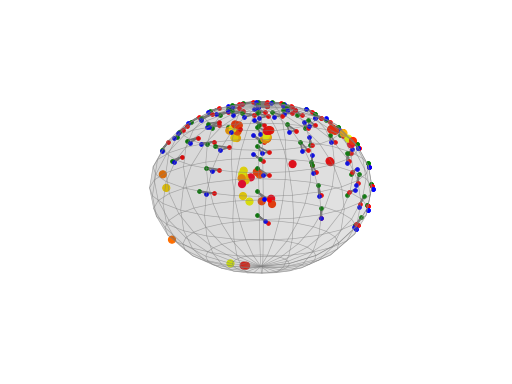

<IPython.core.display.Javascript object>


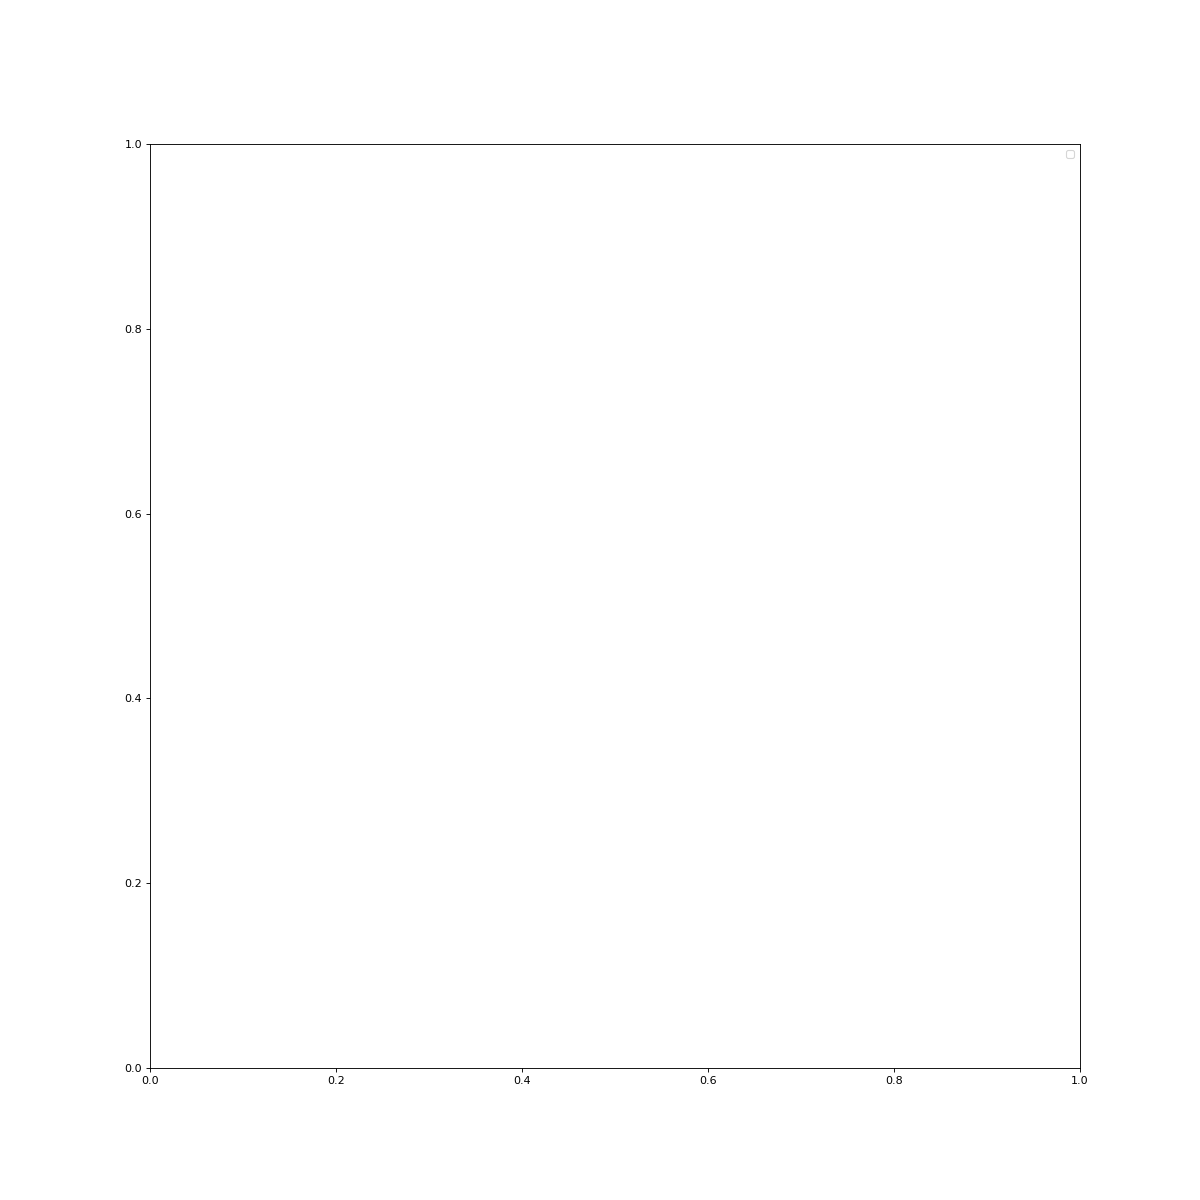

In [24]:
%matplotlib notebook
movie_to_kendall(array)